# ADS Report 

## Import Modules and Create Documents

In [2]:
#import modules
from nltk.tokenize import word_tokenize
from nltk.corpus import brown
from timeit import default_timer as timer
import nltk
from nltk.corpus import semcor
from nltk.corpus import inaugural
from nltk.corpus import stopwords
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import time
from math import sqrt

import operator
from multiprocessing import Pool
from collections import defaultdict

We use nltk's semcor corpus reader to create a collection of 100 documents. 

In [3]:
#collect 100 documents
allfiles = semcor.fileids() #list of fileids
len(allfiles)
semcor_doc = []
for temp in range(100):
    semcor_doc.append(semcor.words(allfiles[temp]))

print(semcor_doc[:5])

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...], ['Committee', 'approval', 'of', 'Gov.', 'Price', ...], ['The', 'Orioles', 'tonight', 'retained', 'the', ...], ['A', 'Texas', 'halfback', 'who', 'does', "n't", ...], ['Rookie', 'Ron', 'Nischwitz', 'continued', 'his', ...]]


## Helper Functions



In [4]:
# time our code blocks
def timeit(somefunc, *args, repeats=10, **kwargs):
    times=[]
    while repeats > 0:
        starttime = time.time()
        ans = somefunc(*args, **kwargs)
        endtime = time.time()
        timetaken = endtime - starttime
        times.append(timetaken)
        repeats -= 1
    
    mean = np.mean(times)
 
    return mean

def token_frequency(tokens):
    freqs = {}
    for token in tokens:
        try :
            freqs[token] += 1
        except KeyError:
            freqs[token] = 1
    return freqs

def normalise(tokenlist):
    tokenlist = [token.lower() for token in tokenlist]
    tokenlist = ["NUM" if token.isdigit() else token for token in tokenlist]
    tokenlist = ["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
    tokenlist = ["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
    return tokenlist

def filter_stopwords(tokenlist):
    stop = stopwords.words('english')
    return [w for w in tokenlist if w.isalpha() and w not in stop]

# create bag-of-words
def make_bow(somestring):
    rep = normalise(somestring)   
    rep = filter_stopwords(rep)  
    dict_rep = {}
    for token in rep:
        dict_rep[token] = dict_rep.get(token, 0) + 1
    return(dict_rep)

my_doc = []
for doc_m in semcor_doc:
    my_doc.append(make_bow(doc_m))
    
print(my_doc[0])

{'fulton': 14, 'county': 15, 'grand': 4, 'jury': 18, 'said': 24, 'friday': 4, 'investigation': 1, 'atlanta': 7, 'recent': 1, 'primary': 4, 'election': 14, 'produced': 1, 'evidence': 1, 'irregularities': 3, 'took': 2, 'place': 4, 'term': 4, 'end': 2, 'presentments': 1, 'city': 9, 'executive': 2, 'committee': 3, 'charge': 2, 'deserves': 1, 'praise': 1, 'thanks': 1, 'manner': 2, 'conducted': 1, 'september': 1, 'october': 1, 'charged': 2, 'superior': 2, 'court': 5, 'judge': 1, 'durwood': 1, 'pye': 1, 'investigate': 1, 'reports': 2, 'possible': 1, 'ivan': 2, 'allen': 2, 'relative': 1, 'handful': 1, 'received': 4, 'considering': 1, 'widespread': 1, 'interest': 2, 'number': 3, 'voters': 4, 'size': 1, 'find': 1, 'many': 2, 'georgia': 8, 'registration': 1, 'laws': 2, 'outmoded': 1, 'inadequate': 1, 'often': 1, 'ambiguous': 1, 'recommended': 4, 'legislators': 4, 'act': 2, 'studied': 1, 'revised': 1, 'modernizing': 1, 'improving': 1, 'commented': 2, 'topics': 1, 'among': 1, 'purchasing': 2, 'depa

In [5]:
# plot our findings
def draw_chart(num_mx, time_my, names):
    logxs=[np.log10(x) for x in num_mx]
    logys=[np.log10(y) for y in time_my]
    
    plt.subplots_adjust(1, 0, 2.5, 0.5)
    plt.subplot(121)
    plt.plot(num_mx,time_my)
    plt.xlabel("Length of List")
    plt.ylabel("Average time")
    plt.title("Worst Case Running Time of "+ names)
    
    plt.subplot(122)
    plt.scatter(logxs, logys)
    plt.xlabel("Length of List")
    plt.ylabel("Average time")
    plt.title("Worst Case Running Time of "+ names)
    plt.show()
    
    return logxs,logys

# calculate the slope of our implementations
def cal_slope(logxs, logys):
    slope, intercept, r_value, p_value, std_err = stats.linregress(logxs, logys)
    print("Slope is {} and intercept is {}".format(slope,intercept))

## 1. Jaccard

### Worst Case Runtime

Jaccard's similarity measures the ratio between the intersection and the union of two sets. The worst case runtime of computing the union is 
$O(len(set 1 keys) + len(set 2 keys))$, and for the intersection: 
$O(len(set 1 keys) * O(len(set 2 keys))$. This gives us a worst case runtime of $O(n)$, where n is the length of the longest set. 

In [10]:
def jac_sim(A, B):
    U = A.keys() | B.keys()
    I = A.keys() & B.keys()
    jac =  len(I) / len(U)
    return jac 

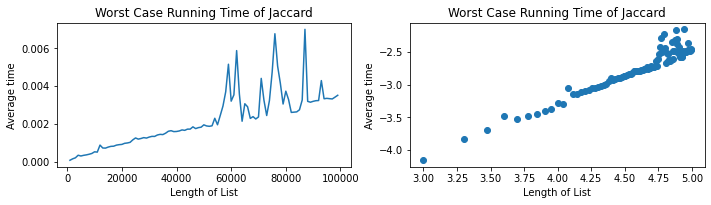

Slope is 0.8733733148208511 and intercept is -6.768635122792161


In [5]:
times = []
lengths = []
for n in range(1000, 100 * 1000, 1000):
    
    A = token_frequency(brown.words()[:n])
    B = token_frequency(brown.words()[n:2*n])
    
    run_time=timeit(jac_sim,A,B)
    lengths.append(n)
    times.append(run_time)

lx, ly = draw_chart(lengths, times, 'Jaccard')
cal_slope(lx, ly)

We have a linear equation describing our line. We have $y=c_a.x^n$ where $c_a$ is the constant. It follows that $\log(y) = \log(c_a) + n \log(x)$, where n is the gradient, and $\log(c_a)$ is the intercept. Our gradient suggests that the runtime is better than our worse case runtime of $O(n)$. This happens because some instructions are executed outside of the inner loop. This difference dissapears for large enough n though. This means that as $n \rightarrow \infty$, the runtime $\rightarrow O(n)$.

## 2. Dense Cosine

### Helper Functions

In [6]:
# transform dictionary into dense vector
def make_matrix(list_of_dicts):
    allfeatures = {}    
    for docdict in list_of_dicts:
        for feat in docdict.keys():
            allfeatures[feat] = 1
    dimensions = list(allfeatures.keys())
    so = sorted(dimensions)
    matrix = []
    for dimension in dimensions:
        row = []
        for docdict in list_of_dicts:
            row.append(docdict.get(dimension, 0))
        matrix.append(row)
          
    return matrix

# transpose matrices so that they can be compared
def transpose(matrix):
    transposed = []
    for i in range(0, len(matrix[0])):
        transposed.append([row[i] for row in matrix])
        
    return transposed

#cosine similarity

def norm(A):
    sq_sum = 0
    for i in range(len(A)):
        sq_sum += A[i] ** 2
    return sq_sum ** 0.5


def cosine_sim(A, B):
    
    dot_prod = 0
    for i in range(len(A)):
        dot_prod += A[i] * B[i]

    normA = norm(A)
    normB = norm(B)
    
    return dot_prod / (normA * normB)

### Worst Case Runtime

Similarly to Jaccard, we iterate ove all arrays and collect the dot product of the documents represented as vectors. This is the main difference between our cosine and jaccard similarities: Our documents are represented densely, meaning they contain all words in all doucments, and the frequencies of words in each document is marked in this vector. We expect this to have $O(n)$ worst case runtime.

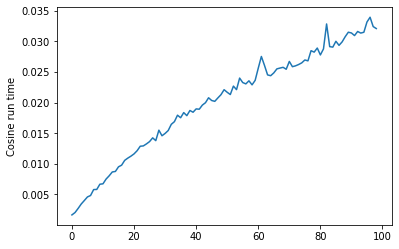

In [7]:
times1 = []
lengths1 = []

for n in range(1000, 100 * 1000, 1000):
    
    A = token_frequency(brown.words()[:n])
    B = token_frequency(brown.words()[n:2*n])
    
    transposed = np.array(transpose(make_matrix([A, B])))
    
    runtime = timeit(cosine_sim, transposed[0], transposed[1])
    times1.append(runtime)
    lengths1.append(n)
    
plt.plot(times1)
plt.ylabel('Cosine run time')
plt.show()

Now we try using numpy's dot product inplace of our own implementation.

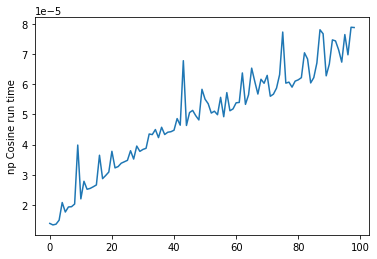

In [8]:
def np_cosine(A, B):
    
    dot_prod = 0
    
    ab = np.dot(A, B)
    aa = np.dot(A, A)
    bb = np.dot(B, B)
    
    return ab / (sqrt(aa) * sqrt(bb))

times2 = []
lengths2 = []

for n in range(1000, 100 * 1000, 1000):
    
    A = token_frequency(brown.words()[:n])
    B = token_frequency(brown.words()[n:2*n])

    transposed = np.array(transpose(make_matrix([A, B])))
    
    runtime = timeit(np_cosine, transposed[0], transposed[1])
    times2.append(runtime)
    lengths2.append(n)
    
plt.plot(times2)
plt.ylabel('np Cosine run time')
plt.show()

The runtime is on average less for np cosine. Since the times are very small, there is large variance. 

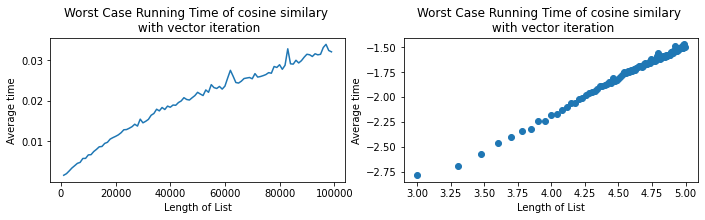

Slope is 0.6987211066947645 and intercept is -4.961666954308869


In [9]:
lx, ly = draw_chart(lengths1, times1, 'cosine similary \n with vector iteration')
cal_slope(lx, ly)

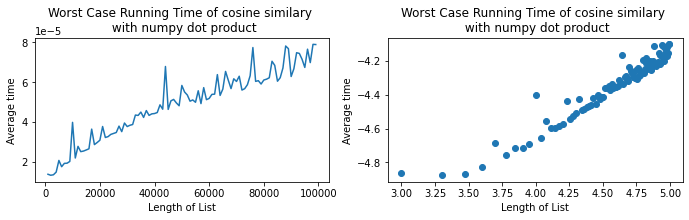

Slope is 0.4520663572520201 and intercept is -6.415048123441872


In [10]:
lx, ly = draw_chart(lengths2, times2,'cosine similary \n with numpy dot product')
cal_slope(lx, ly)

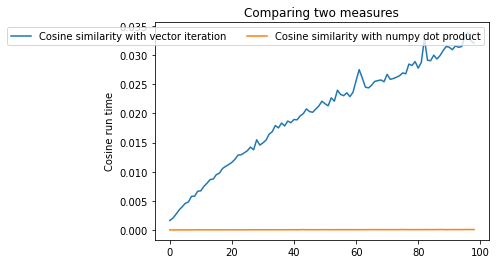

In [11]:
plt.plot(times1)
plt.plot(times2)
plt.title("Comparing two measures")

label = ["Cosine similarity with vector iteration","Cosine similarity with numpy dot product"]
plt.legend(label, loc = 0, ncol = 2)
plt.ylabel('Cosine run time')
plt.show()

We can clearly see that the numpy dot product is more efficient than our custom built one. Despite the plot showing a straight line at 0, the truth is that there is elevation (slope) and the intercept is not 0. It just appears this way becuase the numpy implementation is much better than our custom one. 

Similarly to Jaccard, the runtimes averaged less than $O(n)$. The reason is also the same as the Jaccard implementation. Some executions happen outside of the inner loop much more quickly than those in the loop. This means we will only see $O(n)$ runtime for asymptotically large n.

## 3. Sparse Cosine

We will implement a cosine similarity algorithm where only the tokens in the two compared documents will be compared. This is akin to how we implemented our Jaccard algorithm. 

We redefine a dot product so that the number of tokens being compared is equal to the number of tokens in the document with the most tokens,

In [18]:
def dot(d1, d2):
    if len(d1) < len(d2):
        a = d1
        b = d2
    else:
        a = d2
        b = d1
    dotproduct = 0
    for word, count in a.items():
        dotproduct += count * b.get(word,0)
    return dotproduct

In [20]:
def cos_sim(d1,d2):
    numerator = dot(d1, d2)
    denominator = sqrt(dot(d1, d1) * dot(d2, d2))
    return numerator / denominator

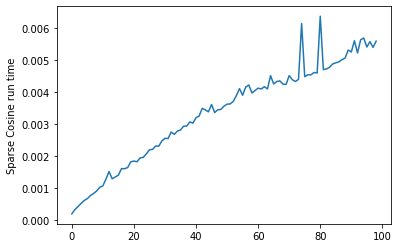

In [12]:
def sparse_cos():
    sparse_times = []
    sparse_lengths = []
    for n in range(1000, 100 * 1000, 1000):
    
        A = token_frequency(brown.words()[:n])
        B = token_frequency(brown.words()[n:2*n])
    
        sparse_lengths.append(n)
        
        runtime = timeit(cos_sim, A, B)
        sparse_times.append(runtime)
   

    plt.plot(sparse_times)
    plt.ylabel('Sparse Cosine run time')
    plt.show()
        
    return sparse_times, sparse_lengths

sparse_cos = sparse_cos()

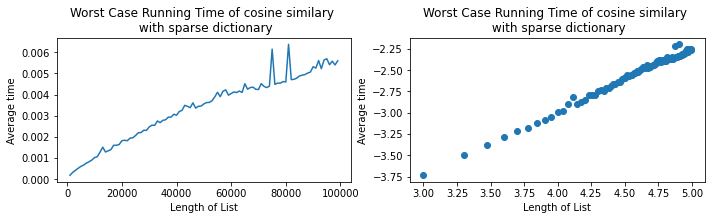

Slope is 0.7496131783093994 and intercept is -5.9791654363188025


In [13]:
lcx,lcy = draw_chart(sparse_cos[1], sparse_cos[0], 'cosine similary \n with sparse dictionary')
cal_slope(lcx,lcy)

We might have expected our sparse implementation to be quicker than our dense implementation. We can see however that the graphs for both the sparse and dense implementations vary greatly, suggesting that the results are difficult to compare for such low values of n.

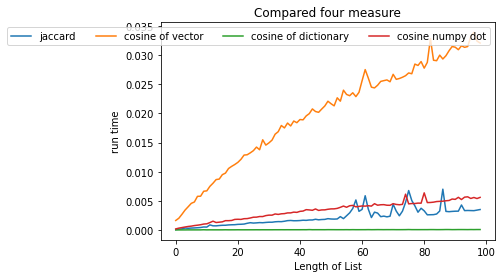

In [15]:
plt.plot(times)   
plt.plot(times1)
plt.plot(times2)
plt.plot(sparse_cos[0])
    
plt.xlabel("Length of List")
plt.title("Compared four measure")
label = ["jaccard", "cosine of vector","cosine of dictionary","cosine numpy dot"]
plt.legend(label, loc = 0, ncol = 4)
plt.ylabel('run time')
plt.show()

We can see that the slopes of the algorithms - with the exception of dense cosine - are similar, as expected. The real shock to me is how much better numpy's dot product has performed compared to our other algorithms. This goes to show the power of efficiently implementing even constant time operations, especially for low values of n.

As for the dense cosine implementation, we would expect this to grow faster than the others for low n. This is because most documents do not have most words in common, meaning that this implementation computes a lot of unnecessary dot prodcuts. This effect would be mitigated for higher n.

## 4. All-Pairs Similarities

We create the all_pair function with two flags: flag 1 will time each individual pair, while flag 2 will time a fixed number of pairs. 

In [16]:
def all_pair(func, flag):
    sims = []
    times =[]
    lengths = []
    k_num = 0
    j_num = 0

    most_similar = (0,0,0)
    
    if flag==1:
        for i in range(len(my_doc) - 1):
            for j in range(i + 1, len(my_doc)):
                start = timer()
                sim_i_j = func(my_doc[i], my_doc[j])
                end = timer()
                k_num = k_num + (end - start)
                times.append(k_num)
                j_num += 1
                lengths.append(j_num)
    else: 
        for numk in range(50):
            my_docs = my_doc[0: numk + 1]
            start = timer()
            k_num = 0
            for i in range(len(my_docs) - 1):
                for j in range(i + 1, len(my_docs)):
                    sim_i_j = func(my_doc[i], my_doc[j])
            end = timer()
            k_num = (end - start)
            times.append(k_num)
            lengths.append(len(my_docs))       
            
    return lengths, times

### Jaccard

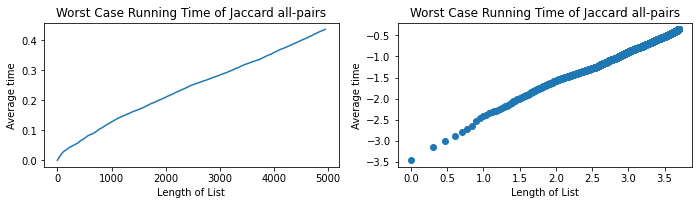

Slope is 0.7464242570362234 and intercept is -3.1348442498524456


In [17]:
xj, yj = all_pair(jac_sim, 1)
lx, ly = draw_chart(xj, yj, 'Jaccard all-pairs')
cal_slope(lx, ly)

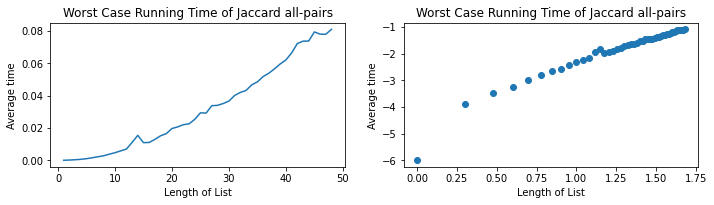

Slope is 2.282593097240562 and intercept is -4.764219450241123


In [18]:
xj, yj = all_pair(jac_sim, 0)
lx, ly = draw_chart(xj, yj, 'Jaccard all-pairs')
cal_slope(lx, ly)

We can see from our first plots that the slope is similar to our first implementation of Jaccard similarity. i.e., there is not a great difference between finding the similarity between pairs of documents, and pairs of large collections of documents since they are both sparsely represented. 

For our second plots, we can see that the runtime is just over $O(n^2)$. This is because as the number of documents grows, so too does the number of pairs that need to be computed, making it non-linear.

Converting our intercept from log we have $c_a$ = .04. Then $y = (.04)(200000)^{0.746} \approx 360$

### Cosine

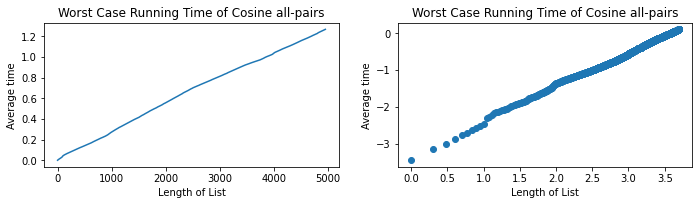

Slope is 0.9252625795951508 and intercept is -3.3162722445680908


In [22]:
xj, yj = all_pair(cos_sim, 1)
lx, ly = draw_chart(xj, yj, 'Cosine all-pairs')
cal_slope(lx, ly)

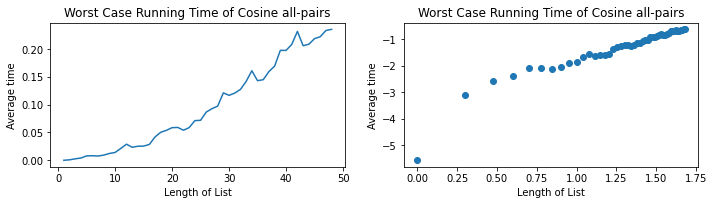

Slope is 2.1053172495103967 and intercept is -4.030892628965357


In [23]:
xj, yj = all_pair(cos_sim, 0)
lx, ly = draw_chart(xj, yj, 'Cosine all-pairs')
cal_slope(lx, ly)

We can draw similar conclusions from our all-pairs Jaccard implementation applied to our all-pairs cosine algorithm. The secondary plot also shows a greater than quadratic runtime due to the nature of the number of pairs being computed as the number of documents increases.

Converting our intercept from log we have $c_a$ = .036. Then $y = (.036)(200000)^{0.925} \approx 2906$

## 5. Parallel Computing 

We will create a MapReduce algorithm for our similarity measures. We will redefine our all_pair function to be simpler and fit the needs of the algorithm. We will create a mapper function and reducer functions for the similarities. We will finally create two test functions that we can use to compare the standard and parallel implementations.

In [8]:
def all_pair(func):
    sims = []
    for i in range(len(my_doc) - 1):
        sims.append([])
        for j in range(i + 1, len(my_doc)):
            sims[i].append([i, j])
    return sims

def parallel_mapper(document):
    output = []
    for num in document:
        output.append((str(num[0]), num))
    return output

def jac_parallel_reducer(item):
    output = []
    (word, counts) = item
    for count in counts:
        A = my_doc[count[0]]
        B = my_doc[count[1]]
        U = A.keys() | B.keys()
        I = A.keys() & B.keys()
        jac =  len(I) / len(U)
        output.append(((count[0],count[1]),jac))
    return output

def cos_parallel_reducer(item):
    output = []
    (word, counts) = item
    for count in counts:
        A = my_doc[count[0]]
        B = my_doc[count[1]]
        numerator = dot(A, B)
        denominator = sqrt(dot(A, A)*dot(B, B))
        cos_sim = numerator / denominator
        output.append(((count[0], count[1]), cos_sim))
    return output

def parallel_map_reduce(docm, mapper, reducer):
    outputs = []
    # store intermediate results in dict
    collector = defaultdict(list)
        
    docm1 = all_pair(docm)
    mapprocesses = 4
    reduceprocesses = 4

    mappool = Pool(processes=mapprocesses)
    mapresults = mappool.map(mapper, docm1)
    mappool.close()
    
    # store intermediate results in dict
    collector = defaultdict(list)
    for mapresult in mapresults:
        for (key, value) in mapresult:
            collector[key].append(value)  


    reducepool = Pool(processes=reduceprocesses)
    reduceresults = reducepool.map(reducer, collector.items())
    reducepool.close()
    for reduceresult in reduceresults:
        outputs += reduceresult
    
    return outputs

def test(func, ti):
    my_docs = my_doc
    k_num=0
    time_collection=[]
    start = timer()

    for tii in range(ti):
        for i in range(len(my_docs) - 1):
            for j in range(i + 1, len(my_docs)):
                sim_i_j = func(my_doc[i], my_doc[j])
                
    end = timer()
    k_num = (end - start)
    time_collection.append(k_num)
    means_time = np.mean(time_collection)
    print('(50 documents all-pair) average running time', means_time)
    return means_time

def test_par(func, my_docs, mapper, reducer, ti):
    my_docs = my_doc
    k_num = 0
    time_collection = []

    for tii in range(ti):
        start = timer()
        parallel_map_reduce(my_docs, mapper, reducer)
  
        end = timer()
        k_num = (end - start)
        time_collection.append(k_num)
        
    means_time = np.mean(time_collection)
    print('(50 documents all-pair) parallel average running time', means_time)
    return means_time

### Jaccard

We compare the runtimes of our two Jaccard implementations.

In [9]:
test_par(parallel_map_reduce, my_doc, parallel_mapper, jac_parallel_reducer, 10)

(50 documents all-pair) parallel average running time 0.33361287980005727


0.33361287980005727

In [11]:
test(jac_sim, 10)

(50 documents all-pair) average running time 6.013552489999711


6.013552489999711

In [15]:
jac_sim_all = parallel_map_reduce(my_doc, parallel_mapper, jac_parallel_reducer)
jac_df = pd.DataFrame(jac_sim_all, columns=['document','similiarity'])
jac_df.head()

,document,similiarity
0,"(0, 1)",0.143830
1,"(0, 2)",0.074879
2,"(0, 3)",0.091792
3,"(0, 4)",0.074675
4,"(0, 5)",0.096541


In [16]:
jac_o = []
for i in range(len(my_doc) - 1):
    for j in range(i + 1, len(my_doc)):
        sim_i_j = jac_sim(my_doc[i], my_doc[j])
        jac_o.append(sim_i_j)
jac_o[:5]

[0.14382978723404255,
 0.0748792270531401,
 0.09179170344218888,
 0.07467532467532467,
 0.09654062751407884]

### Cosine

Compare both cosine implementations

In [19]:
test_par(parallel_map_reduce, my_doc, parallel_mapper, cos_parallel_reducer, 10)

(50 documents all-pair) parallel average running time 0.35691500999964776


0.35691500999964776

In [21]:
test(cos_sim, 10)

(50 documents all-pair) average running time 8.467150283000592


8.467150283000592

In [23]:
cos_sim_all = parallel_map_reduce(my_doc, parallel_mapper, cos_parallel_reducer)
cos_df = pd.DataFrame(cos_sim_all, columns=['document','similiarity'])
cos_df.head()

,document,similiarity
0,"(0, 1)",0.467004
1,"(0, 2)",0.371672
2,"(0, 3)",0.406700
3,"(0, 4)",0.376800
4,"(0, 5)",0.331278


In [24]:
cos_o = []
for i in range(len(my_doc) - 1):
    for j in range(i + 1, len(my_doc)):
        sim_i_j = jac_sim(my_doc[i], my_doc[j])
        cos_o.append(sim_i_j)
cos_o[:5]

[0.14382978723404255,
 0.0748792270531401,
 0.09179170344218888,
 0.07467532467532467,
 0.09654062751407884]

Due to the multithread processing, we can see that our parallel algorithms performed better than their standard counterparts, making them the better choice of implementation.